<a href="https://colab.research.google.com/github/MITHRAN-BALACHANDER/Python/blob/main/sem4_img_captioning_flickr8k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mithranbalachander","key":"818399447a77d3af8d567512f1ad490b"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d hsankesara/flickr-image-dataset
!unzip -q flickr-image-dataset.zip -d flickr30k


Dataset URL: https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset
License(s): CC0-1.0


In [ ]:
!pip install tqdm
!pip install pillow
!pip install pydot
!pip install nltk
!pip install matplotlib

In [ ]:
## import modules
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
BASE_DIR = "flickr8k/Flickr8k_Dataset/Flicker8k_Dataset"

WORKING_DIR = "working"
os.makedirs(WORKING_DIR, exist_ok=True)
print(os.path.exists(BASE_DIR))

True


In [ ]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# extract features from image
features = {}
directory = BASE_DIR #os.path.join(BASE_DIR, 'flickr30k_images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
TEXT_DIR = "flickr8k/Flickr8k_text"

with open(os.path.join(TEXT_DIR, 'Flickr8k.token.txt'), 'r') as f:
    captions_doc = f.read()


In [ ]:
mapping = {}

# process lines
for line in tqdm(captions_doc.strip().split('\n')):
    # remove leading/trailing whitespaces
    line = line.strip()

    # skip empty lines
    if len(line) < 2:
        continue

    # split line into image_id and caption
    tokens = line.split(',', 1)  # Split only at the first comma
    if len(tokens) < 2:
        continue

    image_id, caption = tokens
    image_id = image_id.split('.')[0].strip()
    caption = caption.strip()

    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []

    mapping[image_id].append(caption)
    print(mapping[image_id],image_id)


  0%|          | 0/40460 [00:00<?, ?it/s]

['a red ball next to it .'] 1012212859_01547e3f17
['a red ball next to it .', 'stands on shore shaking off water'] 1012212859_01547e3f17
['facing the water and the city skyline .'] 1022454332_6af2c1449a
['being held by the male , sitting next to a pond with a near by stroller .'] 1022454428_b6b660a67b
['with stick .'] 103106960_e8a41d64f8
['standing on an ice , looking into something covered with a blue tarp .'] 103205630_682ca7285b
['man in background watches .'] 1042590306_95dea0916c
['as seen from behind her .'] 105342180_4d4a40b47f
['one with a yellow and orange ball , play in some water in front of a field .'] 1056249424_ef2a2e041c
['as seen from behind .'] 1056338697_4f7d7ce270
[''] 1072153132_53d2bb1b60
['a man throws a little boy up in the air .'] 1077931201_1e0bb83105
['one smiling , the other sticking his tongue out .'] 1079274291_9aaf896cc1
['and girl and two horses are near a contained fire .'] 10815824_2997e03d76
['a sheep dog , and a boxer standing in a yard .'] 108225256

In [ ]:
len(mapping)

2088

In [ ]:
import re

def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i].lower()  # convert to lowercase

            # delete digits and special characters using regex
            caption = re.sub(r'[^a-z ]', '', caption)

            # delete additional/multiple spaces
            caption = re.sub(r'\s+', ' ', caption).strip()

            # remove short words (length <= 1), add start and end tokens
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'

            # update cleaned caption
            captions[i] = caption


In [ ]:
# before preprocess of text
mapping['766061382_6c7ff514c4']

['is flexing his muscles whilst smiling .',
 'smiling child without a shirt poses with arms raised .']

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
# after preprocess of text
mapping['766061382_6c7ff514c4']

['startseq is flexing his muscles whilst smiling endseq',
 'startseq smiling child without shirt poses with arms raised endseq']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

2447

In [ ]:
all_captions[:10]

['startseq red ball next to it endseq',
 'startseq stands on shore shaking off water endseq',
 'startseq facing the water and the city skyline endseq',
 'startseq being held by the male sitting next to pond with near by stroller endseq',
 'startseq with stick endseq',
 'startseq standing on an ice looking into something covered with blue tarp endseq',
 'startseq man in background watches endseq',
 'startseq as seen from behind her endseq',
 'startseq one with yellow and orange ball play in some water in front of field endseq',
 'startseq as seen from behind endseq']

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

2108

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

23

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

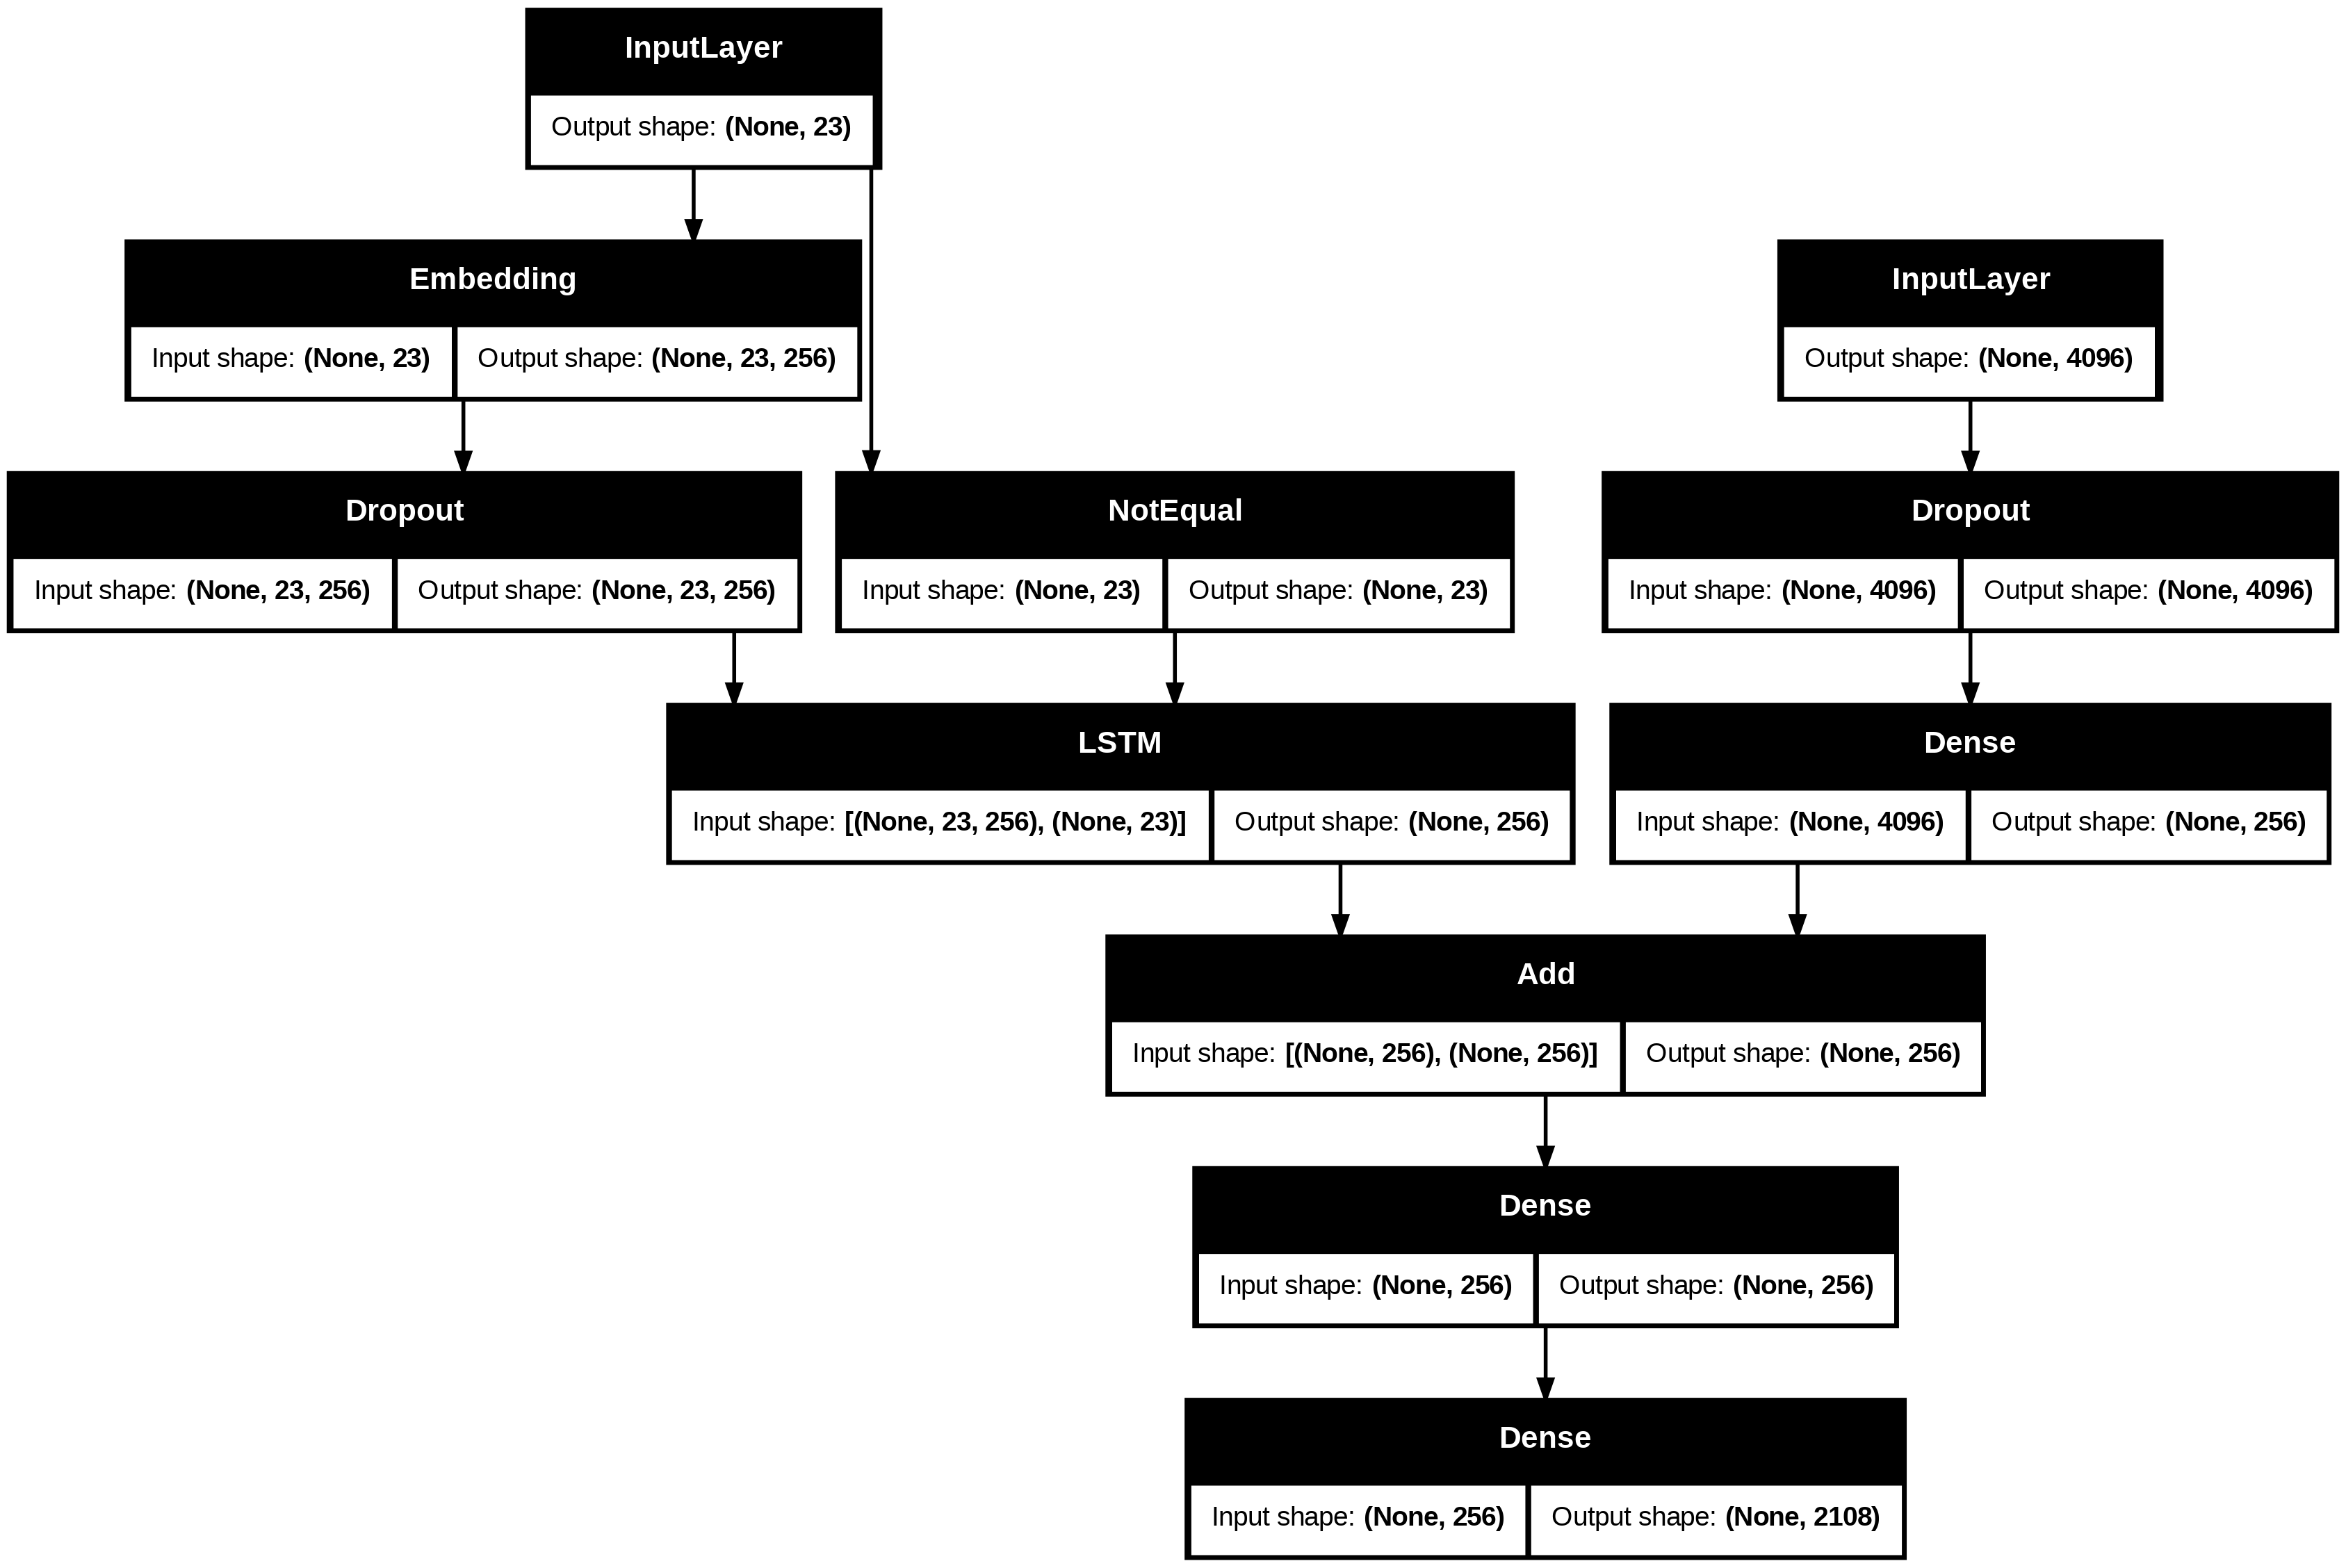

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)


In [ ]:
train = [img_id for img_id in train if img_id in features]


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
early_stopper = EarlyStopping(
    monitor='loss',     # or 'val_loss' if you have validation data
    patience=3,         # stop after 3 epochs of no improvement
    restore_best_weights=True
)


In [ ]:
history_loss = []
epochs = 100
for i in range(epochs):
    print(f"Epoch {i+1}/{epochs}")

    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)

    history = model.fit(
        generator,
        epochs=1,
        steps_per_epoch=steps,
        verbose=1,
        callbacks=[early_stopper]
    )

    # Save loss from this epoch
    history_loss.append(history.history['loss'][0])

    # Break if early stopping was triggered
    if early_stopper.stopped_epoch > 0:
        print(f"Early stopping at epoch {i+1}")
        break


Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.6966
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.6440
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.6200
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.5571
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.5154
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.5092
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.4811
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.4473
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.4444
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.4255
Epoch 11/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.4109
Epoch 12/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.3697
Epoch 13/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.3460
Epoch 14/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.3184
Epoch 15/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - lo

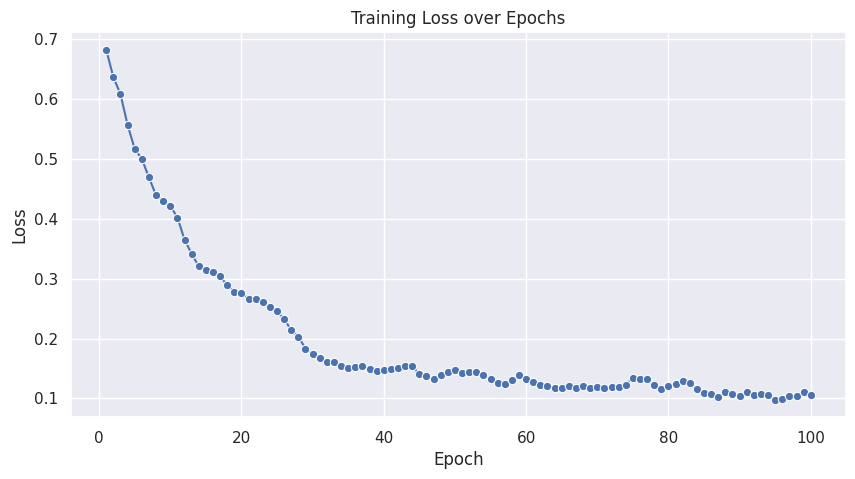

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 5))
sns.lineplot(x=list(range(1, len(history_loss)+1)), y=history_loss, marker="o")
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [ ]:
# Training parameters

batch_size = 32
steps = len(train) // batch_size  # Number of steps per epoch

for i in range(epochs):
    print(f"Epoch {i+1}/{epochs}")

    # Create a new data generator for each epoch (recommended)
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)

    # Fit model for 1 epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 6.2195
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 5.2781
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 4.8996
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 4.5065
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 4.1423
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.7832
Epoch 7/20
42/58 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.4713

KeyboardInterrupt: 

In [ ]:
model.save('best_model.keras')
model.save(os.path.join(WORKING_DIR, 'yolo8n.h5'))
model.save(os.path.join(WORKING_DIR, 'best_model.keras'))



In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Helper function to map index to word
def idx_to_word(index, tokenizer):
    for word, idx in tokenizer.word_index.items():
        if idx == index:
            return word
    return None  # word not found

# Main caption prediction
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'

    for _ in range(max_length):
        # Convert the text to sequence of tokens
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the sequence
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        # Predict the next word
        yhat = model.predict([image, sequence], verbose=0)
        # Get the word with max probability
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)

        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break

    # Remove startseq and endseq from final output
    final_caption = in_text.replace('startseq', '').replace('endseq', '').strip()
    return final_caption


In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/209 [00:00<?, ?it/s]

BLEU-1: 0.091970
BLEU-2: 0.000000
BLEU-1: 0.138418
BLEU-2: 0.000000
BLEU-1: 0.058079
BLEU-2: 0.000000
BLEU-1: 0.051523
BLEU-2: 0.000000
BLEU-1: 0.051265
BLEU-2: 0.000000
BLEU-1: 0.046499
BLEU-2: 0.000000
BLEU-1: 0.039857
BLEU-2: 0.000000
BLEU-1: 0.049124
BLEU-2: 0.000000
BLEU-1: 0.084648
BLEU-2: 0.037483
BLEU-1: 0.071231
BLEU-2: 0.031753
BLEU-1: 0.086928
BLEU-2: 0.054740
BLEU-1: 0.090771
BLEU-2: 0.059879
BLEU-1: 0.095644
BLEU-2: 0.060340
BLEU-1: 0.092662
BLEU-2: 0.058340
BLEU-1: 0.087389
BLEU-2: 0.054981
BLEU-1: 0.088984
BLEU-2: 0.053707
BLEU-1: 0.084678
BLEU-2: 0.051042
BLEU-1: 0.079332
BLEU-2: 0.047993
BLEU-1: 0.080342
BLEU-2: 0.048430
BLEU-1: 0.089688
BLEU-2: 0.050314
BLEU-1: 0.092615
BLEU-2: 0.050292
BLEU-1: 0.088986
BLEU-2: 0.048193
BLEU-1: 0.086819
BLEU-2: 0.047013
BLEU-1: 0.090121
BLEU-2: 0.047469
BLEU-1: 0.090745
BLEU-2: 0.046491
BLEU-1: 0.093933
BLEU-2: 0.046905
BLEU-1: 0.087544
BLEU-2: 0.043748
BLEU-1: 0.088100
BLEU-2: 0.042853
BLEU-1: 0.084535
BLEU-2: 0.041212
BLEU-1: 0.0823

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    image_id = image_name.split('.')[0].strip()
    img_path = os.path.join(BASE_DIR, image_name)

    # Defensive checks
    if not os.path.exists(img_path):
        print(f"[ERROR] Image file not found: {img_path}")
        return

    if image_id not in mapping:
        print(f"[ERROR] Image ID '{image_id}' not found in mapping.")
        print("Available keys (first 5):", list(mapping.keys())[:5])
        return

    if image_id not in features:
        print(f"[ERROR] Features not extracted for image ID '{image_id}'.")
        print("Available feature keys (first 50):", list(features.keys())[:50])
        return

    # Load and show image
    image = Image.open(img_path)

    # Print actual captions
    print('---------------------Actual---------------------')
    for caption in mapping[image_id]:
        print(caption)

    # Predict caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)

    # Show image
    plt.imshow(image)
    plt.axis('off')
    plt.show()


---------------------Actual---------------------
startseq red ball next to it endseq
startseq stands on shore shaking off water endseq
--------------------Predicted--------------------
red ball next to it


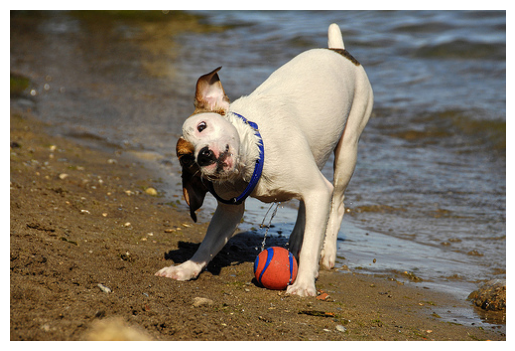

In [ ]:
generate_caption("1012212859_01547e3f17.jpg")

In [ ]:
generate_caption("101669240_b2d3e7f17b.jpg")

[ERROR] Image ID '101669240_b2d3e7f17b' not found in mapping.
Available keys (first 5): ['1012212859_01547e3f17', '1022454332_6af2c1449a', '1022454428_b6b660a67b', '103106960_e8a41d64f8', '103205630_682ca7285b']


In [ ]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs,
                  outputs=vgg_model.layers[-2].output)

In [ ]:
import io
def extract_features_from_uploaded_image(image_file):
    image = Image.open(image_file).convert('RGB')  # 👈 convert to RGB
    image = image.resize((224, 224))
    image = img_to_array(image)
    image = image.reshape((1, 224, 224, 3))
    image = preprocess_input(image)
    feature = vgg_model.predict(image, verbose=0)
    return feature

# Upload image
uploaded = files.upload()

# Process the first uploaded image
for filename in uploaded.keys():
    print(f"\nProcessing: {filename}")
    feature = extract_features_from_uploaded_image(io.BytesIO(uploaded[filename]))
    caption = predict_caption(model, feature, tokenizer, max_length)
    print("\nPredicted Caption:\n", caption)

Saving Screenshot 2025-04-08 091249.png to Screenshot 2025-04-08 091249.png

Processing: Screenshot 2025-04-08 091249.png

Predicted Caption:
 shown at the autos
